## Notebook setup

### Import modules

In [74]:
%matplotlib inline

import os,sys,inspect
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

import shap
import autosklearn.metrics
import sklearn.metrics as sk_metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from model.model_util import *
from model.stats_util import *
warnings.filterwarnings('ignore')

# plot customization
import seaborn as sns
from matplotlib.colors import ListedColormap

### Notebook utilities

In [2]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

### Helper Functions

In [2]:
# row has class condition: cols with accuracy, kappa, prec/recall
def build_clf_results(test_y, preds):
    
    results = np.zeros((len(preds),len(metric_columns)))
    
    for idx, pred in enumerate(preds):
        results[idx, 0] = sk_metrics.accuracy_score(test_y, pred)
        results[idx, 1] = sk_metrics.balanced_accuracy_score(test_y, pred)
        results[idx, 2] = sk_metrics.f1_score(test_y, pred, average='macro')
        results[idx, 3] = sk_metrics.f1_score(test_y, pred, average='micro')
        results[idx, 4] = sk_metrics.f1_score(test_y, pred, average='weighted')
        
    return results

metric_columns = ['accuracy', 'balanced accuracy', 'macro f1', 'micro f1', 'weighted f1']

### Plot formatting

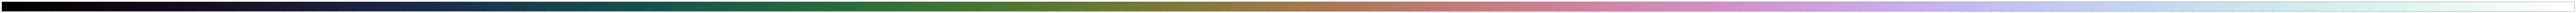

In [121]:
# TODO best color palette for papers?
# cubehelix: for colorblind individuals and black and white
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

sns.set_palette("cubehelix")

font = {
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
#plt.rcParams.update({'figure.autolayout': False})
plt.rcParams["figure.figsize"] = [16, 10]

sns.palplot(sns.color_palette("cubehelix", 256))


# Estimating Relationships and their Meaning from Phone Data: Paper Stats and Figures

## Load data

In [4]:
# load data

# train features
top5_all_sb_train_data = pickle.load(open('../data/final_sandbox/top5_all_train_features.df', 'rb'))
top5_all_sb_test_data = pickle.load(open('../data/final_sandbox/top5_all_test_features.df', 'rb'))

age_qlabels = ["age_q" + str(x) for x in range(1,5)]
top5_all_data = pd.concat([top5_all_sb_train_data, top5_all_sb_test_data], axis=0)
top5_all_data['ego_age_q'], bins = pd.qcut(top5_all_data['ego_age'], q=4, labels=age_qlabels, retbins=True)

In [5]:
# old data
with open("../data/top5_final.df", "rb") as raw_file:
    top5_raw_df = pickle.load(raw_file)
    
with open("../data/all_contacts_final.df", "rb") as raw_file:
    all_raw_df = pickle.load(raw_file)

with open('../data/demographics.df', 'rb') as demo_file:
    demo_df = pickle.load(demo_file)
demo_cols = ['pid', 'age', 'gender', 'education', 'employment', 'live_together', 'race', 'ethnicity', 'marital_status']

## Feature renaming

In [6]:
all_feature_dict = {
    # intensity and regularity
    'mean_in_sms': 'mean incoming SMS frequency',
    'med_in_sms': 'median incoming SMS frequency',
    'med_out_sms': 'median outgoing SMS frequency',
    'max_in_sms': 'Max incoming SMS frequency',
    'max_out_sms': 'Max outgoing SMS frequency',
    'min_in_sms': 'Max incoming SMS frequency',
    'min_out_sms': 'Max outgoing SMS frequency',
    'mean_out_sms': 'mean outgoing SMS frequency',

    'total_comm_days': 'total # communication days',
    'avg_in_duration': 'mean incoming call duration',
    'mean_in_call': 'mean incoming call frequency',
    'std_in_sms': 'standard deviation incoming SMS frequency',
    'std_out_sms': 'standard deviation outgoing SMS frequency',
    'total_comms': 'total # communications',      
    'reg_comm': 'communication regularity',
    'avg_out_duration': 'mean outgoing call duration',
    
    # temporal tendency
    'day_0_sms': 'Monday SMS',
    'time_of_day_0_sms': '12am - 4am SMS',
    'time_of_day_0_comm': '12am - 4am communication',
    'time_of_day_5_sms': '8pm - 12am SMS',
    'time_of_day_2_sms': '8am - 12pm SMS',
    'time_of_day_2_call': '8am - 12pm calls',
    'time_of_day_5_comm': '8pm - 12am communication',


    # channel selection
    'call_tendency': 'call tendency',

    # maintenance cost
    'sms_last_6_wks': 'SMS frequency within last 2 weeks',

    # missing indicators
    'time_of_day_0_sms_nan_indicator': '12am - 4am SMS missing indicator',

    # semantic location  
    'call_visit_reason:errand': 'calls at \"errand\" locations',

    # TODO finish organizing
    'total_sms_days': 'total # texting days',
    'time_of_day_3_calls': '12pm - 4pm calls',
    'time_of_day_4_calls': '4pm - 8pm calls',
    'time_of_day_2_calls': '8am - 12pm calls',
    'day_6_sms': 'Sunday SMS',
    'comm_last_2_wks': 'communication within last 2 weeks',
    'call_dur_last_6_wks': 'call duration within last 2 weeks',
    'day_6_comm': 'Sunday communication',
    'time_of_day_2_sms': '8am - 12pm SMS',
    'time_of_day_1_sms': '4am - 8am SMS',
    'missed_in_calls': 'missed to incoming call ratio',
    'reg_sms': 'texting regularity',
    'call_loc:shop': 'calls at \"shop\" locations',
}

## 3.1 Data Description

### Contact types by communication frequency

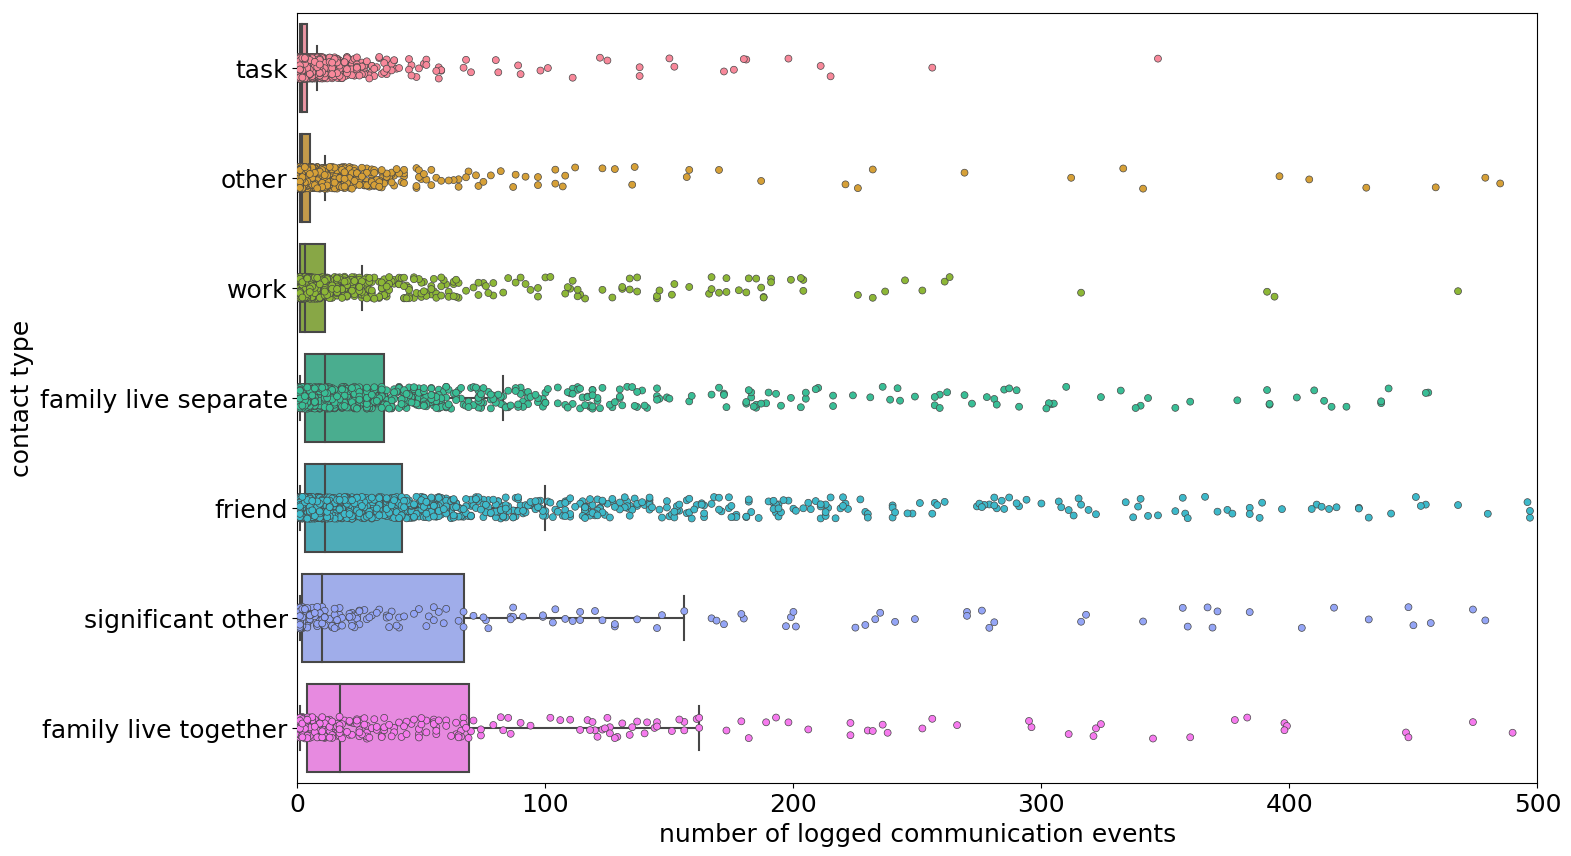

In [131]:
# cell-specific toggles
from matplotlib.patches import Rectangle, PathPatch
plot_strip = True
sns.set_palette("cubehelix")
#sns.set()
#sns.palplot(sns.color_palette())
# x_feat = 'contact_type'
# y_feat = 'comm_type'
y_feat = 'contact_type'
x_feat = 'comm_type'

comm_counts = all_raw_df.groupby('combined_hash').count()['comm_type'].reset_index()
raw_df_unique = all_raw_df.drop_duplicates('combined_hash')
hash_contact_type_dict = pd.Series(raw_df_unique.contact_type.values, index=raw_df_unique.combined_hash).to_dict()
comm_counts['contact_type'] = comm_counts['combined_hash'].map(hash_contact_type_dict)

comm_counts = comm_counts.loc[comm_counts['comm_type'] < 500]

contact_labels = {
    'other': 'other', 
    'family_live_separate': 'family live separate', 
    'friend': 'friend', 
    'task': 'task', 
    'sig_other': 'significant other', 
    'work': 'work', 
    'family_live_together': 'family live together'
}
comm_counts['contact_type'] = comm_counts['contact_type'].map(contact_labels)

ordered_labels = [
    'task',
    'other',
    'work',
    'family live separate',
    'friend',
    'significant other',
    'family live together'
]

fig, ax = plt.subplots()
if plot_strip:
    strip_plot = sns.stripplot(x=x_feat, 
                               y=y_feat,
                               data=comm_counts,
                               #jitter=0.1,
                               linewidth=0.5,
                               order=ordered_labels)
    plt_suffix = "_strip"
else:
    plt_suffix = ""
    
box_plot = sns.boxplot(x=x_feat, 
                       y=y_feat,
                       data=comm_counts, 
                       fliersize=0,
                       order=ordered_labels)

#plt.xticks(rotation=45, ha='right')
plt.xlim(0,500)
plt.ylabel("contact type")
plt.xlabel("number of logged communication events")

plt_name = 'paper_figs/all_contact_types_comm_freq{}.pdf'.format(plt_suffix)

patches = [r for r in ax.get_children() if type(r)==PathPatch]
colors = [c.get_facecolor() for c in patches]
#sns.palplot(sns.color_palette())
#plt.savefig(plt_name, dpi=300, bbox_inches='tight')

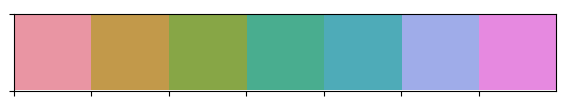

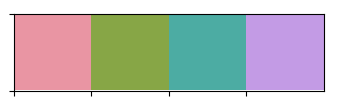

In [132]:
# building final color palette
soc_separate = tuple(np.mean(x) for x in zip(colors[-3], colors[-4]))
fam_together = tuple(np.mean(x) for x in zip(colors[-1], colors[-2]))
task = colors[0]
other = colors[1]
work = colors[2]
sns.palplot(colors)

color_palette = [task, work, soc_separate, fam_together]

sns.palplot(color_palette)

### Semantic Location plot

In [188]:
location_top

array(['Travel Or Transport', 'Nightlife Spot', 'Spiritual',
       'Outdoors & Recreation', 'Arts & Entertainment', 'Work',
       'Professional Or Medical Office', "Another's Home", 'Food', 'Home',
       'Shop Or Store'], dtype='<U60')

In [219]:
# load functions and data
from preprocess import preprocess_location

data_dir = '../data/single_participant_data/'
subject = '1114936'
#subject = '1307899'
folders = os.listdir(data_dir+subject)
 
# reading top locations
with open(data_dir + 'top_locations.dat','rb') as f:
    location_top = pickle.load(f)
f.close()

location_top = ['Travel Or Transport', 'Nightlife Spot', 'Spiritual', 'Outdoors & Recreation', 'Arts & Entertainment', 'Work', 'Food', 'Home', 'Shop Or Store']

# reading data
locs = []
loc_times = []
lats = []
lngs = []

comms = [] # records PHONE,SMS events
comm_pids = [] # records the pids of contacts
comm_times = [] # records communication times

for fold in folders:
    if os.path.isfile(data_dir+subject+'/'+fold+'/eml.csv') and os.path.isfile(data_dir+subject+'/'+fold+'/fus.csv'):
        df = pd.read_csv(data_dir+subject+'/'+fold+'/eml.csv',sep='\t', header=None)
        locs.append(preprocess_location(df.loc[0,6]))
        df = pd.read_csv(data_dir+subject+'/'+fold+'/fus.csv',sep='\t', header=None)
        loc_times.append(np.array(df.loc[:,0])-6*3600)
        lats.append(np.array(df.loc[:,1]))
        lngs.append(np.array(df.loc[:,2]))
        if os.path.isfile(data_dir+subject+'/'+fold+'/coe.csv'):

            df = pd.read_csv(data_dir+subject+'/'+fold+'/coe.csv',sep='\t', header=None)
            comms.append(np.array(df.loc[:,3]))
            comm_pids.append(np.array(df.loc[:,1]))
            comm_times.append(np.array(df.loc[:,0])-6*3600)
        else:
            comms.append([])
            comm_pids.append([])
            comm_times.append([])
    else:
        print('folder {} skipped'.format(fold))
        
loc_times = [loc_times[i] for i in range(len(locs)) if locs[i] in location_top]
lats = [lats[i] for i in range(len(locs)) if locs[i] in location_top]
lngs = [lngs[i] for i in range(len(locs)) if locs[i] in location_top]
comms = [comms[i] for i in range(len(locs)) if locs[i] in location_top]
comm_pids = [comm_pids[i] for i in range(len(locs)) if locs[i] in location_top]
comm_times = [comm_times[i] for i in range(len(locs)) if locs[i] in location_top]

locs = [locs[i] for i in range(len(locs)) if locs[i] in location_top]


import datetime
def timestamp_to_date(t_range):
    ts = []
    for (i,_) in enumerate(t_range):
        ts.append(datetime.datetime.fromtimestamp(t_range[i]).strftime('%m/%d'))
    return ts

def remove_parentheses(ss):
    for (i,_) in enumerate(ss):
        s = ss[i].split('(')
        s = s[0]
        ss[i] = s
    return ss

folder 102 skipped
folder 5 skipped
folder 17 skipped
folder 20 skipped
folder 4 skipped
folder 13 skipped
folder 63 skipped
folder 111 skipped


[2. 2.]
[2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2.]
[1. 1. 1. 1. 1. 1. 1.]
[7. 7. 7. 7. 7. 7.]
[2.]
[7. 7.]
[2.]
[7. 7. 7. 7. 7.]
[7.]
[7. 7.]
[7. 7. 7. 7. 7.]
[7. 7. 7. 7. 7.]
[2. 2. 2.]
[7. 7.]
[2. 2.]
[2. 2. 2. 2. 2.]
[2. 2. 2. 2.]
[1. 1. 1. 1. 1. 1. 1.]
[2. 2.]
[6.]
[7.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
[7.]
[7. 7. 7. 7. 7. 7.]
[2. 2. 2.]
[1. 1.]
[7.]
[1. 1. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 2.]
[2. 2.]
[1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


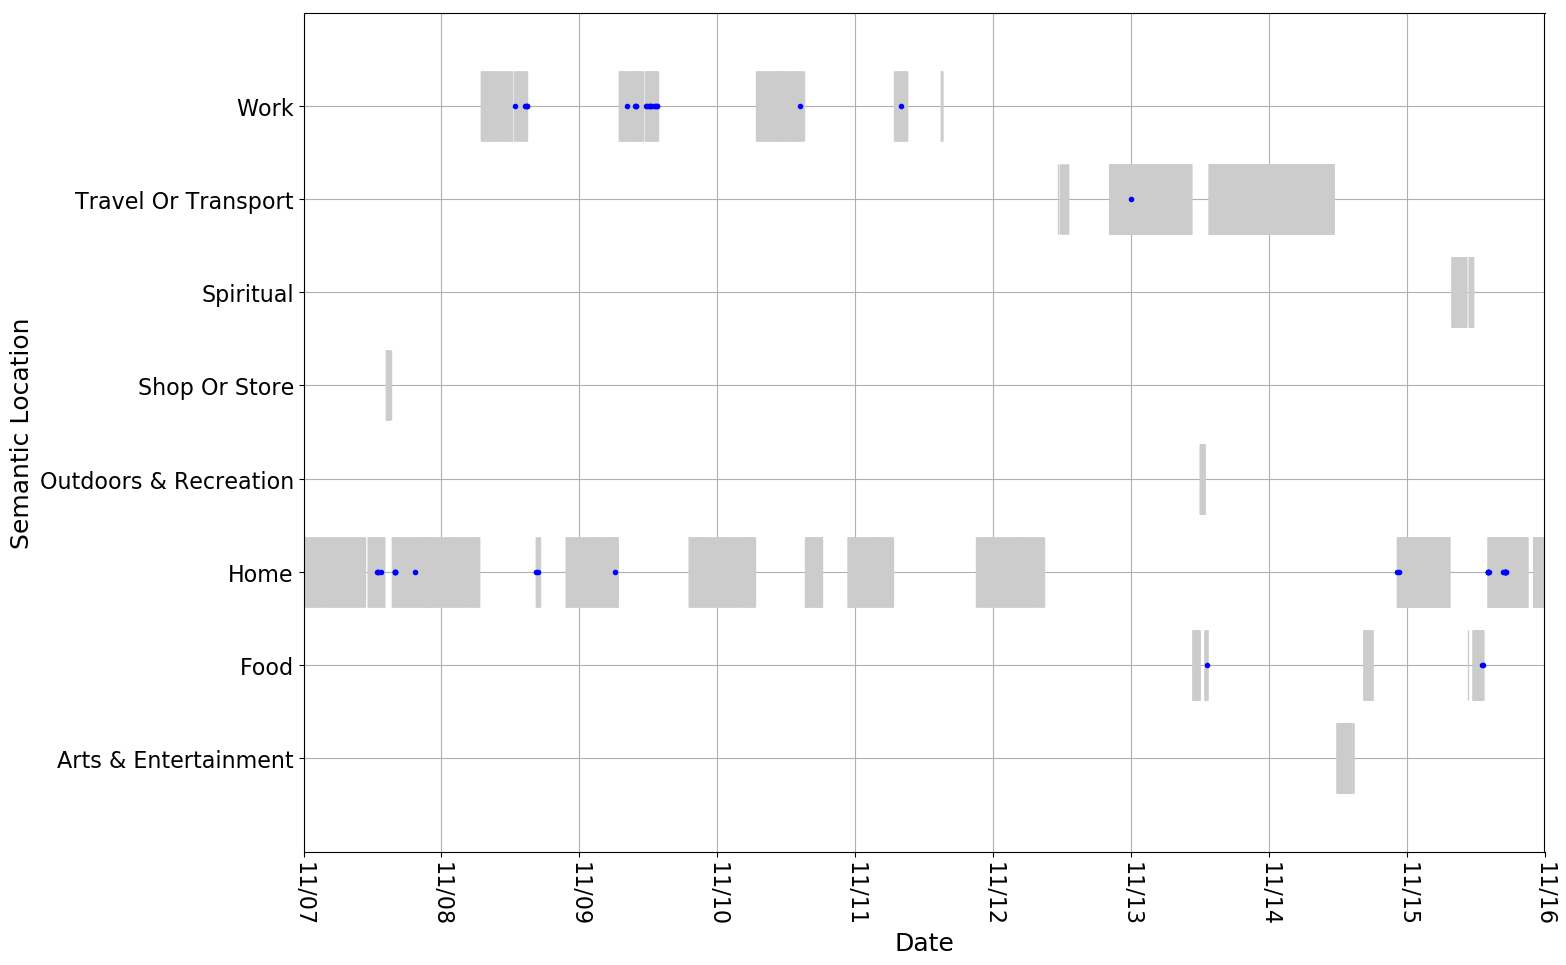

In [230]:
# November 2015
location_uniq = np.unique(locs)
plt.figure(figsize=(16,10))
for (i,loc) in enumerate(locs):
    ind = np.where(location_uniq==loc)[0][0]
    plt.plot(loc_times[i],ind*np.ones(len(loc_times[i])),'|',color=(0.8,0.8,0.8),markersize=50)
    # TODO break out by contact type
    if len(comm_times[i]) > 0:
       plt.plot(comm_times[i],ind*np.ones(len(comm_times[i])),'o',color="blue", markersize=3)
       print(ind*np.ones(len(comm_times[i])))
    
plt.ylim([-1,len(location_uniq)])
t_range = np.arange(1446940800.0, 1446940800.0+10*86400, 86400)
plt.xlim([t_range[0], t_range[t_range.size-1]])
plt.xticks(t_range, timestamp_to_date(t_range), rotation=270, fontsize=16)
plt.yticks(np.arange(len(location_uniq)), remove_parentheses(location_uniq),fontsize=16)
plt.xlabel('Date')
plt.ylabel('Semantic Location')
plt.grid()
plt.tight_layout()


In [184]:
print(loc_times[0][0])
print(comm_times[0][0])

1450563955
1450597116.2729998


### Survey data: contact type

|Question/measure label | Response range|
|-|-|
|contact_type |	{Significant Other, Friend, Family Member You Live With, Family Member You Don't Live With, Colleague/Work-Related, Task (e.g. Make an Appointment, Reservation, etc.), Other}|
|want_question |	{1 (Not At All), 2, 3, 4 (Some), 5, 6, 7 (Extremely Close)}|
|talk_question |	{1 (Strongly Disagree), 2 (Disagree), 3 (Somewhat Disagree), 4 (Neither Agree Or Disagree), 5 (Somewhat Agree), 6 (Agree), 7 (Strongly Agree)}|
|loan_question |	{1 (Strongly Disagree), 2 (Disagree), 3 (Somewhat Disagree), 4 (Neither Agree Or Disagree), 5 (Somewhat Agree), 6 (Agree), 7 (Strongly Agree)} |
|closeness |	{1 (Not At All), 2, 3, 4 (Some), 5, 6, 7 (Extremely Close)} |

In [5]:
print("{} total SMS".format(all_raw_df.loc[all_raw_df['comm_type'] == 'SMS'].shape[0]))

print("{} total calls".format(all_raw_df.loc[all_raw_df['comm_type'] == 'PHONE'].shape[0]))

print("All contact type counts")
all_raw_df.drop_duplicates('combined_hash').groupby('contact_type').count()[['comm_direction']]

337480 total SMS
49872 total calls
All contact type counts


,comm_direction
contact_type,
family_live_separate,1227
family_live_together,317
friend,1738
other,1925
sig_other,288
task,2231
work,1186


In [6]:
print("Contacts per participant")
all_raw_df.groupby("pid")['combined_hash'].nunique().describe()

Contacts per participant


count    200.000000
mean      44.560000
std       26.978614
min        1.000000
25%       25.000000
50%       37.500000
75%       58.000000
max      159.000000
Name: combined_hash, dtype: float64

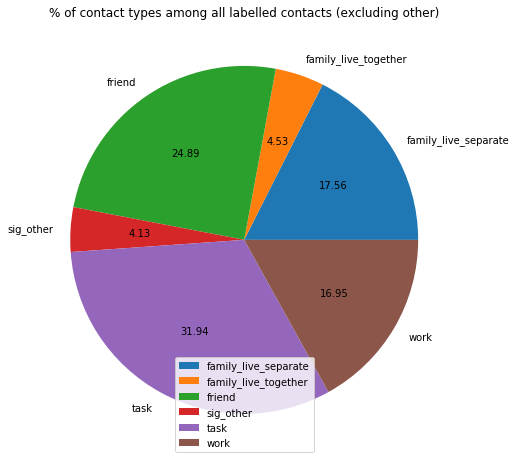

In [7]:
all_types = all_raw_df.loc[all_raw_df['contact_type'] != 'other']
all_types = all_types.drop_duplicates('combined_hash').groupby('contact_type').count()
all_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types among all labelled contacts (excluding other)')
plt.legend(loc='lower center')
plt.ylabel("")
plt.show()

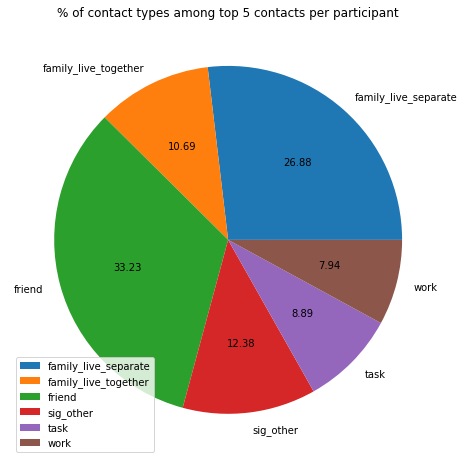

In [8]:
top_types = top_5_raw_df.drop_duplicates('combined_hash').groupby('contact_type').count()
top_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types among top 5 contacts per participant')
plt.legend(loc='lower left')
plt.ylabel("")
plt.show()

In [9]:
top_count = 5
contact_counts = all_raw_df.groupby(['pid'])['combined_hash'].nunique()
drop_contacts = contact_counts.loc[(contact_counts < top_count)].index
coe_contact = all_raw_df.loc[~all_raw_df['pid'].isin(drop_contacts)]

coe_contact_top = all_raw_df.groupby(['pid', 'combined_hash']).count()
g = coe_contact_top['comm_direction'].groupby(level=0, group_keys=False)
top_hashes = g.nlargest(top_count).index.to_frame()['combined_hash'].values
top_contacts = all_raw_df.loc[all_raw_df['combined_hash'].isin(top_hashes)]

In [10]:
#top_contacts.drop_duplicates('combined_hash').groupby('contact_type').count()

In [11]:
print("Top five contact type counts")
display(top_types[['comm_type']])

Top five contact type counts


,comm_type
contact_type,
family_live_separate,254
family_live_together,101
friend,314
sig_other,117
task,84
work,75


## Appendix: Six-class relationship prediction

In [12]:
metric_columns = ['accuracy', 'balanced accuracy', 'macro f1', 'weighted f1']


# row has class condition: cols with accuracy, kappa, prec/recall
def build_clf_results(test_y, preds):
    
    results = np.zeros((len(preds),len(metric_columns)))
    
    for idx, pred in enumerate(preds):
        results[idx, 0] = sk_metrics.accuracy_score(test_y, pred)
        results[idx, 1] = sk_metrics.balanced_accuracy_score(test_y, pred)
        results[idx, 2] = sk_metrics.f1_score(test_y, pred, average='macro')
        results[idx, 3] = sk_metrics.f1_score(test_y, pred, average='weighted')
        
    return results

# load default data
replace_dict = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 3,
        "family_live_together": 4,
        "sig_other": 5
    }
}

contact_types = list(replace_dict['contact_type'].keys())

# load data
top_5_baseline_train = pickle.load(open('../data/rd2_features/top_5_baseline_train_features.df', 'rb'))
top_5_baseline_test =  pickle.load(open('../data/rd2_features/top_5_baseline_test_features.df', 'rb'))

train_data = top_5_baseline_train.replace(replace_dict)
test_data = top_5_baseline_test.replace(replace_dict)

train_y = train_data['contact_type']
train_X = train_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)
test_y = test_data['contact_type']
test_X = test_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)

features = ['baseline', 'age_gender', 'demo', 'all']
preds_6clf = []
idx_6clf = []

# add majority baseline
majority_baseline = [1] * len(test_y)
preds_6clf.append(majority_baseline)
idx_6clf.append("majority baseline")

# load predictions
for feat in features:
    with open("../model/rand_forest_top_5_{}_contact_type.predict".format(feat), 'rb') as pred_file:
        preds_6clf.append(pickle.load(pred_file))
        idx_6clf.append(feat + " RF")
        
for feat in features:
    with open("../model/final_results/top5/top5_{}_automl_6clf_final.predict".format(feat), 'rb') as pred_file:
        preds_6clf.append(pickle.load(pred_file))
        idx_6clf.append(feat + " AutoML")

In [13]:
metrics_6clf = build_clf_results(test_y, preds_6clf)
result_df = pd.DataFrame(metrics_6clf,index=idx_6clf, columns=metric_columns)
pd.options.display.float_format = '{:,.4f}'.format

display(result_df)
print(result_df.to_latex())

,accuracy,balanced accuracy,macro f1,weighted f1
majority baseline,0.3381,0.1667,0.0842,0.1709
baseline RF,0.4000,0.2994,0.2899,0.3559
age_gender RF,0.4476,0.3543,0.3627,0.4123
demo RF,0.4476,0.3330,0.3291,0.3905
all RF,0.4333,0.3733,0.3577,0.4106
baseline AutoML,0.4524,0.3617,0.3534,0.4113
age_gender AutoML,0.4619,0.4150,0.4294,0.4523
demo AutoML,0.4571,0.3818,0.3926,0.4344
all AutoML,0.4619,0.4178,0.4261,0.4517


\begin{tabular}{lrrrr}
\toprule
{} &  accuracy &  balanced accuracy &  macro f1 &  weighted f1 \\
\midrule
majority baseline &    0.3381 &             0.1667 &    0.0842 &       0.1709 \\
baseline RF       &    0.4000 &             0.2994 &    0.2899 &       0.3559 \\
age\_gender RF     &    0.4476 &             0.3543 &    0.3627 &       0.4123 \\
demo RF           &    0.4476 &             0.3330 &    0.3291 &       0.3905 \\
all RF            &    0.4333 &             0.3733 &    0.3577 &       0.4106 \\
baseline AutoML   &    0.4524 &             0.3617 &    0.3534 &       0.4113 \\
age\_gender AutoML &    0.4619 &             0.4150 &    0.4294 &       0.4523 \\
demo AutoML       &    0.4571 &             0.3818 &    0.3926 &       0.4344 \\
all AutoML        &    0.4619 &             0.4178 &    0.4261 &       0.4517 \\
\bottomrule
\end{tabular}



In [15]:
all_automl_6clf = pickle.load(open("../model/final_results/top5/top5_all_automl_6clf_final.automl", "rb"))
all_ensemble = all_automl_6clf.get_models_with_weights()
print_ensemble(all_ensemble)

[WARNING] [11:57:36:autosklearn.util.backend] Could not delete output dir: /tmp/autosklearn_output_25398_449
[WARNING] [11:57:36:autosklearn.util.backend] Could not delete tmp dir: /tmp/autosklearn_tmp_25398_449


Weight: 0.5800000000000001, classifier: adaboost
Weight: 0.08000000000000002, classifier: lda
Weight: 0.04000000000000001, classifier: gradient_boosting
Weight: 0.04000000000000001, classifier: multinomial_nb
Weight: 0.04000000000000001, classifier: xgradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: gradient_boosting
Weight: 0.020000000000000004, classifier: extra_trees
Weight: 0.020000000000000004, classifier: random_forest
Weight: 0.020000000000000004, classifier: lda
Weight: 0.020000000000000004, classifier: random_forest
Weight: 0.020000000000000004, classifier: adaboost


In [ ]:
types_abbrv = ['W', 'F', 'T', 'FLS', 'FLT', 'SO']
print(contact_types)
print(collections.Counter(test_y))
print(collections.Counter(automl_preds[-1]))

confuse_df = print_confusion_matrix(test_y, preds_6clf[-3], types_abbrv)

In [ ]:
print(confuse_df.to_latex())

## 4.1: Four-class relationship prediction

In [27]:
replace_dict_4clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "family_live_separate": 1,
        "task": 2,
        "family_live_together": 3,
        "sig_other": 3
    }
}


predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]


#train_data_4clf = top_5_baseline_train.replace(replace_dict_4clf)
#test_data_4clf = top_5_baseline_test.replace(replace_dict_4clf)

#test_y_4clf = test_data_4clf['contact_type']

# load the results
preds_4clf = []
idx_4clf = []
data_4clf = []

# majority prediction
majority_baseline = [1] * len(test_y_4clf)
preds_4clf.append(majority_baseline)
idx_4clf.append("majority baseline")
data_4clf.append("N/A")

features = ['baseline', 'age_gender', 'demo', 'all']

for feat in features:
    with open("../model/rd3_results/top_5_contact_type_{}_rf_short.predict".format(feat), 'rb') as pred_file:
        preds_4clf.append(pickle.load(pred_file))
        idx_4clf.append("Random forest")
        data_4clf.append(feat)

with open("../model/rd3_results/top_5_contact_type_all_long.predict", 'rb') as pred_file:
    preds_4clf.append(pickle.load(pred_file))
    idx_4clf.append("AutoML")
    data_4clf.append("all")       

with open("../model/rd3_results/top5_ag_only.predict", 'rb') as pred_file:
    preds_4clf.append(pickle.load(pred_file))
    idx_4clf.append("AutoML")
    data_4clf.append("age/gender only")           
    
for feat in features[:-1]:
    with open("../model/rd3_results/top_5_contact_type_{}.predict".format(feat), 'rb') as pred_file:
        preds_4clf.append(pickle.load(pred_file))
        idx_4clf.append("AutoML")
        data_4clf.append(feat)

with open("../model/rd3_results/top_5_contact_type_all_long.predict", 'rb') as pred_file:
    preds_4clf.append(pickle.load(pred_file))
    idx_4clf.append("AutoML")
    data_4clf.append("all")       

In [28]:
from collections import Counter
metrics_4clf = build_clf_results(test_y_4clf, preds_4clf)
results_4clf = pd.DataFrame(metrics_4clf, columns=metric_columns)

results_4clf = pd.concat([pd.Series(idx_4clf, name='model'),
                          pd.Series(data_4clf, name='features'),
                          results_4clf], axis=1)
pd.options.display.float_format = '{:,.4f}'.format

display(results_4clf)
print(results_4clf.to_latex(index=False))

,model,features,accuracy,balanced accuracy,macro f1,micro f1,weighted f1
0,majority baseline,N/A,0.5714,0.2500,0.1818,0.5714,0.4156
1,Random forest,baseline,0.6667,0.4590,0.4795,0.6667,0.6254
2,Random forest,age_gender,0.6667,0.4566,0.4750,0.6667,0.6225
3,Random forest,demo,0.6667,0.4369,0.4598,0.6667,0.6213
4,Random forest,all,0.6762,0.4546,0.4744,0.6762,0.6326
5,AutoML,all,0.7095,0.5221,0.5519,0.7095,0.6806
6,AutoML,age/gender only,0.5714,0.2500,0.1818,0.5714,0.4156
7,AutoML,baseline,0.6571,0.4598,0.4731,0.6571,0.6195
8,AutoML,age_gender,0.6905,0.5310,0.5488,0.6905,0.6654
9,AutoML,demo,0.7095,0.5344,0.5598,0.7095,0.6775


\begin{tabular}{llrrrrr}
\toprule
             model &         features &  accuracy &  balanced accuracy &  macro f1 &  micro f1 &  weighted f1 \\
\midrule
 majority baseline &              N/A &    0.5714 &             0.2500 &    0.1818 &    0.5714 &       0.4156 \\
     Random forest &         baseline &    0.6667 &             0.4590 &    0.4795 &    0.6667 &       0.6254 \\
     Random forest &       age\_gender &    0.6667 &             0.4566 &    0.4750 &    0.6667 &       0.6225 \\
     Random forest &             demo &    0.6667 &             0.4369 &    0.4598 &    0.6667 &       0.6213 \\
     Random forest &              all &    0.6762 &             0.4546 &    0.4744 &    0.6762 &       0.6326 \\
            AutoML &              all &    0.7095 &             0.5221 &    0.5519 &    0.7095 &       0.6806 \\
            AutoML &  age/gender only &    0.5714 &             0.2500 &    0.1818 &    0.5714 &       0.4156 \\
            AutoML &         baseline &    0.6571 & 

## 4.2 Feature importance

### Age/gender model

In [153]:
# Load data and models
ag_predict_proba = pickle.load(open("../model/feature_importance/age_gender.predict_proba", "rb"))
ag_shap_vals = pickle.load(open("../model/feature_importance/age_gender.shap_values", "rb"))

predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]



age_gender_train_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_train_features.df', 'rb'))
age_gender_test_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_test_features.df', 'rb'))

age_gender_train_data = age_gender_train_data.replace(replace_dict)
age_gender_test_data = age_gender_test_data.replace(replace_dict)

age_gender_train_y = age_gender_train_data['contact_type']
age_gender_train_X = age_gender_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
age_gender_test_y = age_gender_test_data['contact_type']
age_gender_test_X = age_gender_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')


In [ ]:
shap.initjs()

In [ ]:
age_gender_explainer = shap.KernelExplainer(ag_predict_proba, shap.kmeans(age_gender_train_X, 10), link="logit")

In [ ]:
shap.force_plot(age_gender_explainer.expected_value[0], ag_shap_vals[0], age_gender_test_X, link="logit")

In [ ]:
feature_names = age_gender_test_X.columns.values
feature_dict = {
    'total_comm_days': 'total # communication days',
    'time_of_day_5_sms': '8pm - 12am texts',
    'time_of_day_3_calls': '12pm - 4pm calls',
    'time_of_day_4_calls': '4pm - 8pm calls',
    'time_of_day_2_calls': '8am - 12pm calls',
    'time_of_day_5_calls': '8pm - 12am calls',
    'day_6_sms': 'Sunday texts',
    'total_comms': 'total # communications',
    'time_of_day_4_sms': '4pm - 8pm texts',
    'avg_in_duration_nan_indicator': 'call feature missing indicator',
    'time_of_day_2_sms': '8am - 12pm texts',
    'day_0_sms': 'Monday texts',
    'time_of_day_0_sms': '12am - 4am texts',
    'time_of_day_1_sms': '4am - 8am texts',
    'total_sms': 'total # texts',
    'total_call_days': 'total # call days',
    'avg_in_duration': 'mean incoming call duration',
    'day_1_sms': 'Tuesday texts', 
    'day_3_sms': 'Thursday texts',
    'day_5_calls': 'Saturday calls',
}

feature_names = list(map(lambda x: feature_dict[x] if x in feature_dict else x, feature_names))

In [ ]:
font = {
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [8,8]
plt.rcParams.update({'figure.autolayout': True})

contact_types = ["work", "social separate", "task", "family together"]
shap.summary_plot(ag_shap_vals, age_gender_test_X, plot_type='dots', show=False, class_names=contact_types, feature_names=feature_names, max_display=20)
#plt.title("Top 20 features by SHAP contribution")

#plt.ylabel("features")
#plt.tight_layout()

plt.savefig("../tex/figures/top5_ag_shap_no_title.png", dpi=300, bbox_inches='tight')

### All features model

In [46]:
# Load data and models
all_predict_proba = pickle.load(open("../model/feature_importance/all.predict_proba", "rb"))
all_shap_vals = pickle.load(open("../model/feature_importance/all.shap_values", "rb"))

predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]

replace_dict = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "family_live_separate": 1,
        "task": 2,
        "family_live_together": 3,
        "sig_other": 3
    }
}


all_train_data = pickle.load(open('../data/final_features_jan28/top_5_all_train_features.df', 'rb'))
all_test_data = pickle.load(open('../data/final_features_jan28/top_5_all_test_features.df', 'rb'))

all_train_data = all_train_data.replace(replace_dict)
all_test_data = all_test_data.replace(replace_dict)

all_train_y = all_train_data['contact_type']
all_train_X = all_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
all_test_y = all_test_data['contact_type']
all_test_X = all_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')


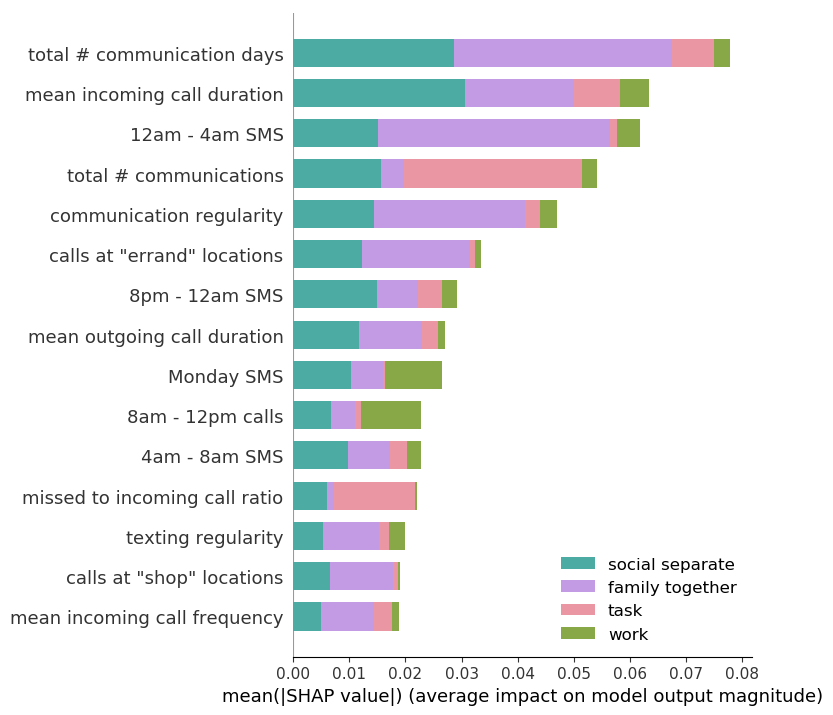

In [67]:
feat_imp_palette = [soc_separate, fam_together, task, work]
palette_cmap = ListedColormap(feat_imp_palette)

all_feature_names = all_test_X.columns.values
all_feature_names = list(map(lambda x: all_feature_dict[x] if x in all_feature_dict else x, all_feature_names))
all_explainer = shap.KernelExplainer(all_predict_proba, shap.kmeans(all_train_X, 10), link="logit")

# font = {
#         'weight' : 'normal',
#         'size'   : 14}

# plt.rc('font', **font)
#plt.rcParams.update({'figure.autolayout': False})
#plt.rcParams["figure.figsize"] = [8, 8]

contact_types = ["work", "social separate", "task", "family together"]
shap.summary_plot(all_shap_vals, 
                  all_test_X, 
                  plot_type='violin', 
                  show=False, 
                  class_names=contact_types, 
                  feature_names=all_feature_names, 
                  max_display=15,
                  color = palette_cmap)
#plt.title("Top 20 features by SHAP contribution")

#plt.ylabel("features")
plt.tight_layout()

plt.savefig("paper_figs/top5_all_shap.pdf", dpi=300, bbox_inches='tight')

In [191]:
len(all_feature_names)

243

In [192]:
len(all_shap_vals[0][0])

243

## 4.3 Feature correlations

### Age Interaction with Communication Patterns

In [15]:
corr_df = top5_all_data.drop(labels=['pid','combined_hash', 'contact_type', 'ego_age_q'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')

In [29]:
exclude_cols = corr_df.columns[corr_df.columns.str.startswith('ego') 
                               | corr_df.columns.str.startswith('q')
                               | corr_df.columns.str.contains('loc') 
                               | corr_df.columns.str.contains('visit_reason')
                               | corr_df.columns.str.contains('nan_indicator')]  

In [47]:
cols = corr_df.columns.values
age_idx = np.where(cols=='ego_age')
sig_age_df = get_sig_features(cols, 'ego_age', r_corrs, r_p_vals, exclude_cols=exclude_cols, alpha=0.01)
pd.reset_option('display.float_format')
pd.options.display.float_format = '{:,.3f}'.format
display(sig_age_df)
sig_age_df.index = sig_age_df.index.map(all_feature_dict)
sig_age_df['p'] = sig_age_df['p'].replace({0.000: '<0.001'})
print(sig_age_df.to_latex())

,corr,p
call_tendency,0.181,0.000
time_of_day_0_comm,-0.146,0.000
time_of_day_0_sms,-0.145,0.000
time_of_day_5_sms,-0.141,0.000
reg_sms,-0.139,0.000
day_6_sms,-0.132,0.000
total_sms_days,-0.131,0.000
comm_last_2_wks,0.129,0.001
day_6_comm,-0.128,0.001
max_in_sms,-0.118,0.002


\begin{tabular}{lrr}
\toprule
{} &   corr &     p \\
\midrule
call tendency                             &  0.181 & 0.000 \\
12am - 4am communication                  & -0.146 & 0.000 \\
12am - 4am SMS                            & -0.145 & 0.000 \\
8pm - 12am SMS                            & -0.141 & 0.000 \\
texting regularity                        & -0.139 & 0.000 \\
Sunday SMS                                & -0.132 & 0.000 \\
total \# texting days                      & -0.131 & 0.000 \\
communication within last 2 weeks         &  0.129 & 0.001 \\
Sunday communication                      & -0.128 & 0.001 \\
Max incoming SMS frequency                & -0.118 & 0.002 \\
NaN                                       & -0.116 & 0.002 \\
standard deviation incoming SMS frequency & -0.111 & 0.004 \\
call duration within last 2 weeks         &  0.110 & 0.005 \\
mean incoming SMS frequency               & -0.110 & 0.005 \\
median incoming SMS frequency             & -0.108 & 0.006 \\
NaN    

## 4.3 LOWESS plots

In [99]:
map_dict = {
    "friend": "social",
    "family_live_separate": "social",
    "family_live_together": "family_together",
    "sig_other": "family_together",
    "work": "work",
    "task": "task"
}

In [153]:
# LOWESS plots
import matplotlib.patheffects as mpe
outline=mpe.withStroke(linewidth=4, foreground='black')

def bootstrap_lowess(df, x_col, y_col, color, label, n_bootstraps=100, n_samples=100):

    x_min = df[x_col].min()
    x_max = df[x_col].max()
    sample_y = np.zeros((n_bootstraps, n_samples))
    sample_x = np.zeros((n_bootstraps, n_samples))


    for i in range(n_bootstraps):
        resampled_df = resample(df, n_samples=n_samples)
        x = resampled_df[x_col]
        y = resampled_df[y_col]

        filtered = lowess(y, x, return_sorted=True, frac=0.66, it=2)
        sample_y[i, :] = filtered[:, 1]
        sample_x[i, :] = filtered[:, 0]

    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 97.5, axis=0), color=color, ls='--')#, path_effects=[outline])
    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 50, axis=0), color=color, label=label)#, path_effects=[outline])
    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 2.5, axis=0), color=color, ls='--')#, path_effects=[outline])
    plt.legend()

groups = {
    'social separate': ['family_live_separate', 'friend', 'social'],
    'work': ['work'],
    'family together': ['family_live_together', 'sig_other', 'family_together'],
    'task': ['task']
}

# colors = {
#     'social separate': 'blue',
#     'work': 'green',
#     'family together': 'orange',
#     'task': 'purple'
# }    

colors = {
    'social separate': soc_separate,
    'work': work,
    'family together': fam_together,
    'task': task
}    
    
def plot_all_bootstrap_lowess(features, x_col, y_col, ylim, yticks, xlim, xticks, n_bootstraps=100):
    fig = plt.figure()
    fig.add_subplot(111, frameon=False)
    subplot_num = 321
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    for label, contact_types in groups.items():
        plt.subplot(subplot_num)
        df = features.loc[features['contact_type'].isin(contact_types)]
        bootstrap_lowess(df, x_col, y_col, colors[label], label, n_bootstraps=n_bootstraps, n_samples=100)
        plt.ylim(ylim)
        plt.yticks(yticks)
        plt.xlim(xlim)
        plt.xticks(xticks)
        
        subplot_num += 1

### Night (8 pm - 12 am) texts

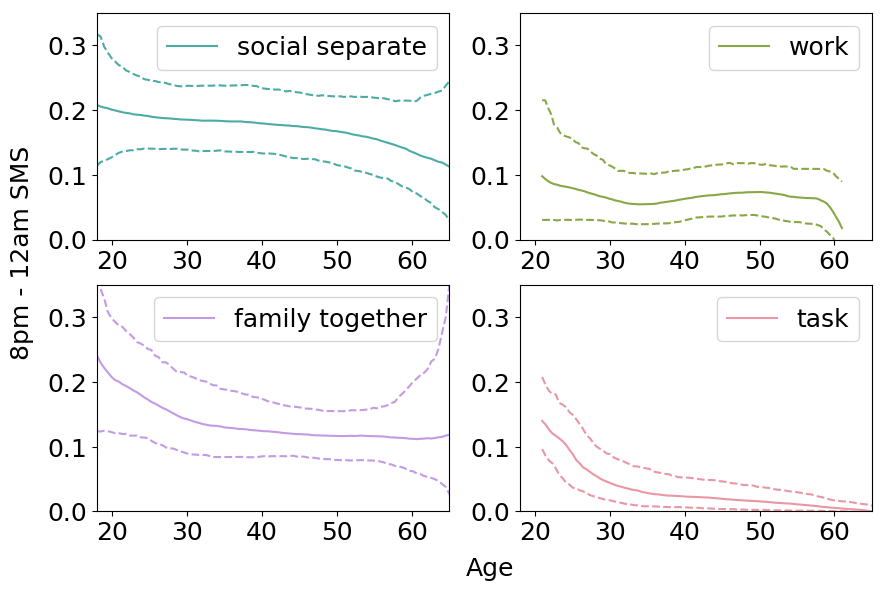

In [154]:
# cell-specific toggle
target = 'time_of_day_5_sms'
target_caption = "8pm - 12am SMS"
# target = 'time_of_day_0_sms'
# target_caption = "12am - 4am SMS"



font = {
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
#plt.rcParams.update({'figure.autolayout': False})
plt.rcParams["figure.figsize"] = [10, 10]

#plot_all_bootstrap_lowess(ag_features, 'ego_age', target, (0,0.35), np.arange(0, 0.35, 0.1), (18, 65), np.arange(20, 66, 10), 1000)

plot_all_bootstrap_lowess(top5_all_data, 'ego_age', target, (0,0.35), np.arange(0, 0.35, 0.1), (18, 65), np.arange(20, 66, 10), 1000)
#plt.suptitle("test LOWESS of {} as a function of {}")
plt.text(14, -0.1, "Age", ha='center')
plt.text(-50, 0.4, target_caption, va='center', rotation='vertical')
plt.savefig("paper_figs/lowess_time_of_day_5.pdf", dpi=300, bbox_inches='tight')

### Total Communication

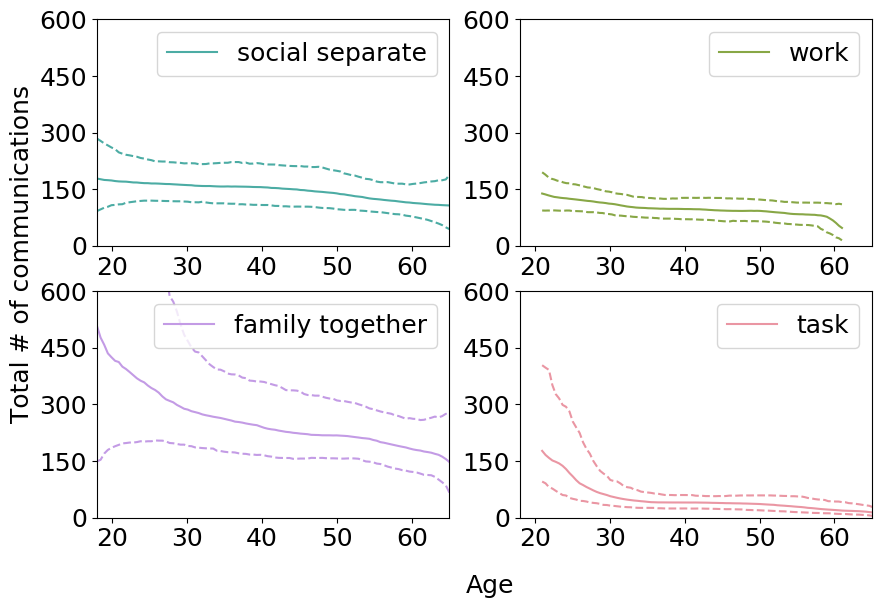

In [155]:
#plot_all_bootstrap_lowess(ag_features, 'ego_age', 'total_comms', (0,600), np.arange(0, 601, 150), (18, 65), np.arange(20, 66, 10), 1000)
plot_all_bootstrap_lowess(top5_all_data, 'ego_age', 'total_comms', (0,600), np.arange(0, 601, 150), (18, 65), np.arange(20, 66, 10), 1000)

plt.text(14, -200, "Age", ha='center')
plt.text(-50, 700, "Total # of communications", va='center', rotation='vertical')
plt.savefig("paper_figs/lowess_total_comms.pdf", dpi=300, bbox_inches='tight')

## 5.1 Subgroup data description

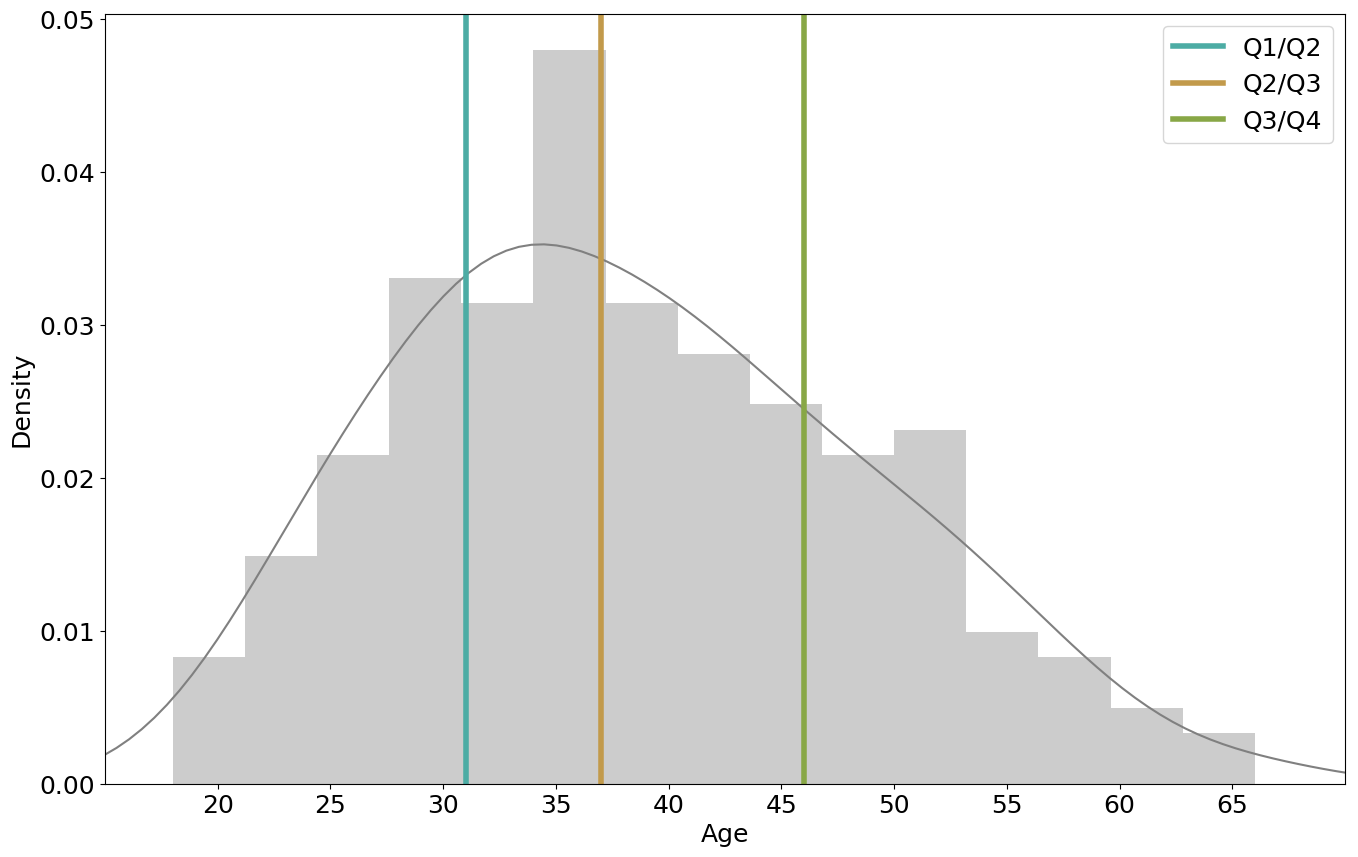

In [169]:
#top5_all_data.drop_duplicates(subset='pid')['ego_age'].hist(bins=15)
plt.rcParams["figure.figsize"] = [16, 10]

with sns.color_palette("cubehelix"):
    palette_cmap = ListedColormap(feat_imp_palette)
    age_data = top5_all_data.drop_duplicates(subset='pid')['ego_age']
    sns.distplot(age_data, bins=15, kde=True, norm_hist=True, color='grey')
    plt.ylabel("Density")
    plt.xlabel("Age")
    plt.xlim((15,70))
    plt.xticks(np.arange(20, 66, 5))
    plt.axvline(x=31, color=soc_separate, label="Q1/Q2", linewidth=4)
    plt.axvline(x=37, color=other, label="Q2/Q3", linewidth=4)
    plt.axvline(x=46, color=work, label="Q3/Q4", linewidth=4)
#     plt.axvline(x=31, label="Q1/Q2")
#     plt.axvline(x=37, label="Q2/Q3")
#     plt.axvline(x=46, label="Q3/Q4")
    plt.legend()
    plt.savefig("paper_figs/q_age_hist.pdf", dpi=300, bbox_inches='tight')
    #plt.title("Distribution of ego age across all participants")

## Sandbox: out of sample test set results

In [12]:
replace_dict_4clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "family_live_separate": 1,
        "task": 2,
        "family_live_together": 3,
        "sig_other": 3
    }
}


predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]

with open("../data/age_features/top5_comm_train_features.df", "rb") as train_f:
    train_data_4clf = pickle.load(train_f)
with open("../data/age_features/top5_comm_test_features.df", "rb") as test_f:
    test_data_4clf = pickle.load(test_f)

train_data_4clf = train_data_4clf.replace(replace_dict_4clf)
test_data_4clf = test_data_4clf.replace(replace_dict_4clf)
test_y_4clf = test_data_4clf['contact_type']

age_features = ['age', 'comm', 'age_comm', 'all']

In [19]:
# load the results
preds_4clf = []
idx_4clf = []
data_4clf = []

# majority prediction
majority_baseline = [1] * len(test_y_4clf)
preds_4clf.append(majority_baseline)
idx_4clf.append("majority baseline")
data_4clf.append("N/A")

# TODO random forest runs
# for feat in age_features:
#     with open("../model/rd3_results/top_5_contact_type_{}_rf_short.predict".format(feat), 'rb') as pred_file:
#         preds_4clf.append(pickle.load(pred_file))
#         idx_4clf.append("Random forest")
#         data_4clf.append(feat)

for feat in age_features:
    with open("../model/age_results/{}_automl.predict".format(feat), 'rb') as pred_file:
        preds_4clf.append(pickle.load(pred_file))
        idx_4clf.append("AutoML weighted")
        data_4clf.append(feat)
        
for feat in age_features:
    with open("../model/age_results/{}_automl_macro.predict".format(feat), 'rb') as pred_file:
        preds_4clf.append(pickle.load(pred_file))
        idx_4clf.append("AutoML macro")
        data_4clf.append(feat)

In [20]:
metrics_4clf = build_clf_results(test_y_4clf, preds_4clf)
results_4clf = pd.DataFrame(metrics_4clf, columns=metric_columns)

results_4clf = pd.concat([pd.Series(idx_4clf, name='model'),
                          pd.Series(data_4clf, name='features'),
                          results_4clf], axis=1)
pd.options.display.float_format = '{:,.4f}'.format

display(results_4clf)
print(results_4clf.to_latex(index=False))

,model,features,accuracy,balanced accuracy,macro f1,micro f1,weighted f1
0,majority baseline,N/A,0.5714,0.2500,0.1818,0.5714,0.4156
1,AutoML weighted,age,0.5714,0.2500,0.1818,0.5714,0.4156
2,AutoML weighted,comm,0.6524,0.5328,0.5404,0.6524,0.6433
3,AutoML weighted,age_comm,0.6810,0.5268,0.5388,0.6810,0.6592
4,AutoML weighted,all,0.6952,0.5183,0.5358,0.6952,0.6699
5,AutoML macro,age,0.4000,0.3301,0.3167,0.4000,0.4181
6,AutoML macro,comm,0.6667,0.5710,0.5701,0.6667,0.6620
7,AutoML macro,age_comm,0.6762,0.5481,0.5423,0.6762,0.6612
8,AutoML macro,all,0.6762,0.5580,0.5407,0.6762,0.6630


\begin{tabular}{llrrrrr}
\toprule
             model &  features &  accuracy &  balanced accuracy &  macro f1 &  micro f1 &  weighted f1 \\
\midrule
 majority baseline &       N/A &    0.5714 &             0.2500 &    0.1818 &    0.5714 &       0.4156 \\
   AutoML weighted &       age &    0.5714 &             0.2500 &    0.1818 &    0.5714 &       0.4156 \\
   AutoML weighted &      comm &    0.6524 &             0.5328 &    0.5404 &    0.6524 &       0.6433 \\
   AutoML weighted &  age\_comm &    0.6810 &             0.5268 &    0.5388 &    0.6810 &       0.6592 \\
   AutoML weighted &       all &    0.6952 &             0.5183 &    0.5358 &    0.6952 &       0.6699 \\
      AutoML macro &       age &    0.4000 &             0.3301 &    0.3167 &    0.4000 &       0.4181 \\
      AutoML macro &      comm &    0.6667 &             0.5710 &    0.5701 &    0.6667 &       0.6620 \\
      AutoML macro &  age\_comm &    0.6762 &             0.5481 &    0.5423 &    0.6762 &       0.6612 \\
 